In [41]:
import numpy 
import scipy.optimize as sp
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import pandas as pd
from astropy.time import Time
import astropy.units as u

In [3]:
df = pd.read_csv('Master_Data.csv')
df

,Cadence (Burst),JD_UTC,av_rel_flux T1,av_rel_flux C2,av_rel_flux C3,av_rel_flux C4,av_rel_flux C5,std_T1,std_C2,std_C3,std_C4,std_C5,CoV T1,CoV C2,CoV C3,CoV C4,CoV C5
0,9-1,2458634.522,0.456628,0.233339,0.339823,0.326439,0.451546,0.002471,0.000887,0.002142,0.002114,0.002726,0.54115,0.37997,0.63035,0.64751,0.60380
1,1-2,2458577.078,0.450170,0.228931,0.339605,0.335194,0.447539,0.002006,0.001622,0.002960,0.003196,0.003580,0.44550,0.70851,0.87161,0.95335,0.80001
2,1-3,2458578.134,0.450683,0.228680,0.340786,0.331198,0.451231,0.003543,0.001859,0.002193,0.002973,0.004438,0.78622,0.81300,0.64345,0.89761,0.98360
3,1-4,2458579.073,0.443331,0.227401,0.341038,0.337236,0.445611,0.002052,0.001855,0.004357,0.002738,0.004142,0.46282,0.81586,1.27755,0.81188,0.92961
4,1-5,2458580.129,0.455698,0.230386,0.337893,0.331528,0.451841,0.001656,0.001190,0.001391,0.002025,0.002493,0.36350,0.51657,0.41154,0.61085,0.55166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,25-2,2458772.319,0.448605,0.228226,0.346733,0.314918,0.464618,0.002445,0.000960,0.001108,0.002206,0.002236,0.54492,0.42065,0.31969,0.70064,0.48121
77,25-5,2458775.310,0.464657,0.229137,0.344663,0.318101,0.461843,0.001035,0.001213,0.001444,0.001581,0.002703,0.22272,0.52943,0.41903,0.49709,0.58524
78,25-6,2458776.310,0.468700,0.231277,0.346630,0.313944,0.461648,0.001667,0.000976,0.001777,0.003936,0.003895,0.35564,0.42185,0.51270,1.25377,0.84377
79,26-3,2458781.313,0.470187,0.229390,0.346115,0.312454,0.467016,0.005155,0.004178,0.005852,0.011035,0.011951,1.09639,1.82156,1.69085,3.53160,2.55910


Text(0, 0.5, 'Flux')

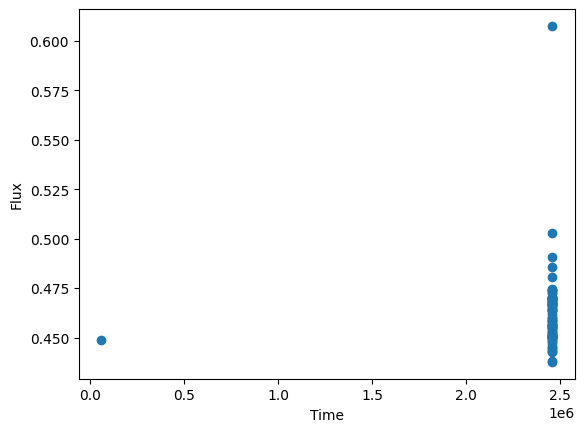

In [4]:
time = df['JD_UTC']
flux = df['av_rel_flux T1']
error = df['std_T1']

plt.scatter(time, flux)
#plt.xlim(2.45e6,2.46e6)
plt.xlabel('Time')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

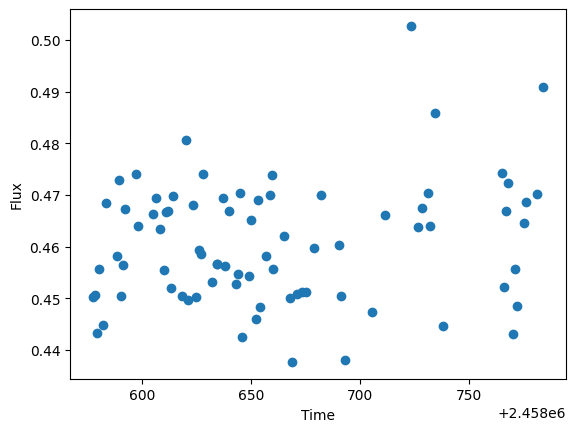

In [5]:
# CLEANED DATA SET

dropped = df.drop([30,63]) # use this one
dropped.where(df['JD_UTC'] < 2.4e6).dropna()

d_time = dropped['JD_UTC'] # time
d_flux = dropped['av_rel_flux T1'] # signal
d_error = dropped['std_T1']
plt.scatter(d_time, d_flux)
plt.xlabel('Time')
plt.ylabel('Flux')


In [6]:
# ROBERT QUIMBY VIDEO - MANUAL METHOD
# frequency is 1/period -> plot period instead of frequency


t_man = dropped['JD_UTC'] 
flux_man = dropped['av_rel_flux T1'] - np.mean(dropped['av_rel_flux T1'])
error_man = dropped['std_T1']

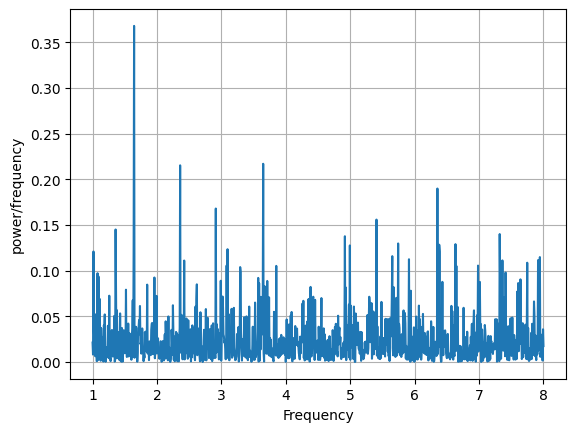

In [7]:
def get_model(params, freq, times):
    A, phi = params
    return A * np.cos(2 * np.pi * freq * times + phi)

def get_chisq(params, times, freq, values):
    model = get_model(params, freq, times)
    return np.sum((values - model)**2)
    
freqs = np.linspace(1, 8, 1000)
Y = np.matrix([[value] for value in flux_man])
A2, chisq = [], []

for freq in freqs:
    thetas = 2 * np.pi * freq * t_man
    X = np.matrix([[np.cos(theta), np.sin(theta)]for theta in thetas])
    p = (X.T * X).I * (X.T * Y)
    B, C = p.A1
    A = B/np.abs(B) * np.hypot(B,C)
    A2.append(A**2)
    phi = np.arctan(-C/B)
    chisq.append(get_chisq((A, phi), t_man, freq, flux_man))
chisq = np.array(chisq)
A2 = np.array(A2)
chisq0 = np.sum((flux_man - np.mean(flux_man))**2)
P = (chisq0 - chisq)/chisq0

plt.plot(freqs, P)
plt.xlabel("Frequency")
plt.ylabel("power/frequency")
plt.grid();

In [8]:
# ROBERT QUIMBY VIDEO - ASTROPY METHOD

t_astro = dropped['JD_UTC'] * u.day
mags = dropped['av_rel_flux T1'] - np.mean(dropped['av_rel_flux T1']) * u.mag
ls = LombScargle(t_astro, mags, d_error)
freqs = np.linspace(1, 8, 1000)
power = ls.power(freqs)

plt.plot(freqs, power)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid();

NameError: name 'u' is not defined

In [ ]:
max_power = power[power == max(power)]
max_power_index = np.where(power == max_power)[0]
best_fit_period = freqs[max_power_index]
print(best_fit_period)

In [ ]:
ls.false_alarm_probability(power.max())

In [ ]:
ls.model_parameters(5.601)

In [ ]:
ls.model(t_astro, 5.601)

In [ ]:
ls, power = LombScargle(t_astro, mags, d_error).autopower()

In [ ]:
plt.figure(figsize = (12, 6))

t_end = 8

plt.xlim(1, t_end)
plt.ylim(0, 0.5)
plt.plot(1/ls, power)
plt.xticks(np.arange(1, t_end, 0.2))

plt.xlabel("Period (Days)")
plt.ylabel("Lomb Scargle Power")
plt.grid()

In [ ]:
period = 1/ls

In [ ]:


# time is in julian date, period is in days

In [ ]:
plt.figure()
plt.scatter(times, d_flux)

In [ ]:
times = np.array(dropped["JD_UTC"])

decimal_years = Time(times, format = "jd")
decimal_years.format = "ymdhms"

decimal_years.to_value("ymdhms")

array = np.array([])
for i in decimal_years:
    array = np.append(array, len(array))




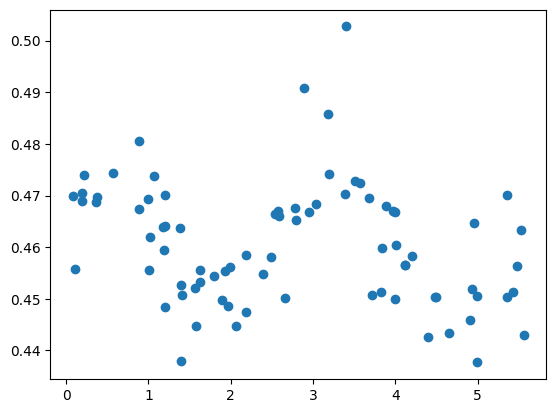

In [13]:
phase_folded_time = d_time % 5.598
# https://astronomy.stackexchange.com/questions/49579/how-do-i-phase-fold-the-light-curve-for-a-variable-star
# phase folded time is just t % P


plt.scatter(phase_folded_time, d_flux)

In [56]:
import scipy.optimize as fit

# https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy

def sine(t, A, w, p, c):  
    return A * numpy.sin(w*t + p) + c
# A: amplitude, w: frequency, p: phase shift, d: vertical offset

p0 = [.01, .36, .5, .45]

In [63]:
par, cov = fit.curve_fit(sine, phase_folded_time, d_flux, p0)

In [64]:
par

array([ 2.04304831e+01,  6.03536730e-03,  1.56754665e+00, -1.99672828e+01])

In [65]:
cov

array([[ 9.24184672e+09, -1.36522531e+06,  7.35438787e+05,
        -9.24184673e+09],
       [-1.36522531e+06,  2.01674016e+02, -1.08640693e+02,
         1.36522531e+06],
       [ 7.35438787e+05, -1.08640693e+02,  5.85246305e+01,
        -7.35438788e+05],
       [-9.24184673e+09,  1.36522531e+06, -7.35438788e+05,
         9.24184674e+09]])

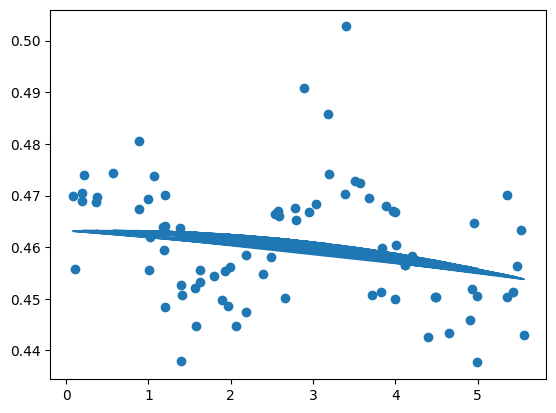

In [67]:
plt.figure()
plt.scatter(phase_folded_time, d_flux)
plt.plot(phase_folded_time, sine(phase_folded_time, par[0], par[1], par[2], par[3]))